## Some boring imports

In [45]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
sys.path.append('../tests')
from utils import get_testdata_path, get_tmp_path

import numpy as np
from skimage.transform import warp
from matplotlib import pyplot as plt
from pyproj import CRS
import rasterio as rio
from pyspatialkit.storage.geostorage import GeoStorage
from pyspatialkit.dataobjects.georaster import GeoRaster
from pyspatialkit.spacedescriptors.georect import GeoRect
from pyspatialkit.storage.raster.georasterlayer import GeoRasterLayer
from pyspatialkit.crs.geocrs import NoneCRS, GeoCrs
from pyspatialkit.tiling.geoboxtiler2d import GeoBoxTiler2d
from pyspatialkit.dataobjects.geoshape import GeoShape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## We got some aerial images to play with

### 1. load them

In [19]:
crs = GeoCrs(CRS.from_epsg(3857))

In [20]:
raster1 = GeoRaster.from_file(get_testdata_path() / "dop100rgbi_32_734_5748_2_st_2020.tif", band=[1,2,3])
raster2 = GeoRaster.from_file(get_testdata_path() / "dop100rgbi_32_736_5748_2_st_2020.tif", band=[1,2,3])
#raster1.to_crs(web_crs)
#raster2.to_crs(web_crs)

In [61]:
storage = GeoStorage(directory_path=get_tmp_path() / 'geostorage')

In [60]:
#storage.delete()

### 3. create a layer in our integrated storage and call it MyCoolAerialData

In [62]:
aoi_bounds = [1378484,6768794,1388093,6774253]
raster_layer = storage.add_raster_layer('MyCoolAerialData', raster1.shape[2], raster1.dtype, crs=crs, bounds=aoi_bounds)
result_layer = storage.add_raster_layer('Result',  raster1.shape[2], raster1.dtype, crs=crs, bounds=aoi_bounds)

### 4. Dump our images into our new layer (takes some time to generate image pyramids for faster read access later on)

In [68]:
raster_layer.begin_pyramid_update_transaction()
raster_layer.writer_raster_data(raster1)
raster_layer.writer_raster_data(raster2)
raster_layer.commit_pyramid_update_transaction()

db request took: 0.3928036689758301
backend request took: 0.39339208602905273
aligned
(3386, 3377)
db request took: 0.26944613456726074
backend request took: 0.2697014808654785
aligned
(3387, 3379)
UPDATING PYRAMIDS


In [69]:
def transformer_fct(georaster: GeoRaster) -> GeoRaster:
    mask = np.argmax(georaster.data, axis=2) == 1
    georaster.data[~mask] = 0
    return georaster   

In [70]:
aoi = GeoShape.from_shapefile(get_testdata_path() / "test_area_two_polygons.shp")
tiler = GeoBoxTiler2d(aoi=aoi, raster_size=(1000,1000), reference_crs=crs)

In [73]:
raster_layer.apply(tiler, transformer_fct, result_layer, resolution_rc=(1000,1000))

db request took: 0.049979448318481445
backend request took: 0.051614999771118164
aligned
(1000, 1000)
db request took: 0.03327202796936035
backend request took: 0.03389406204223633
aligned
(1000, 1000)
db request took: 0.062288761138916016
backend request took: 0.06255340576171875
aligned
(1000, 1000)
db request took: 0.03513932228088379
backend request took: 0.035338401794433594
aligned
(1000, 1000)
db request took: 0.04973030090332031
backend request took: 0.05049490928649902
aligned
(1000, 1000)
db request took: 0.04829859733581543
backend request took: 0.04850316047668457
aligned
(1000, 1000)
db request took: 0.019870281219482422
backend request took: 0.020512819290161133
aligned
(1000, 1000)
db request took: 0.03895759582519531
backend request took: 0.04118704795837402
aligned
(1000, 1000)
db request took: 0.04575061798095703
backend request took: 0.04645371437072754
aligned
(1000, 1000)
db request took: 0.04542350769042969
backend request took: 0.045616865158081055
aligned
(1000,

In [50]:
bounds_rect = GeoRect.from_bounds([*raster1.georect.get_bounds()[:2], *raster2.georect.get_bounds()[2:]], crs=raster1.crs)

got bounds:[1379969 6769962 1386573 6773197]
to Indexes:[1056 1485 4291 8089]
db request took: 3.9978342056274414
backend request took: 4.011102199554443
aligned
(3235, 6604)
reshape aligned
resize took: 0.15149760246276855


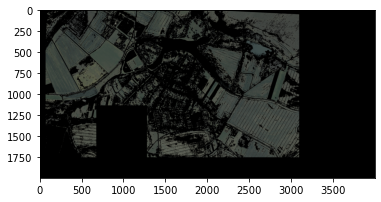

In [51]:
res = result_layer.get_raster_for_rect(bounds_rect, no_data_value=int(0), resolution_rc=(2000,4000))
res.plot()

In [ ]:
storage.plot_cesium()